---
# Homework 5
## CS 189, Spring 2021
## Author: Hieu Nguyen 
## SID: 26369732
---

# Problem 3

---

### Utils

In [ ]:
import numpy as np
import sklearn.model_selection
from numpy import genfromtxt
import sklearn.tree
import scipy.io
from scipy import stats
from collections import Counter

eps = 1e-5  # a small number

def preprocess(data, fill_mode=True, min_freq=4, onehot_cols=[]):
    # fill_mode = False

    # Temporarily assign -1 to missing data
    data[data == b''] = '-1'

    # Hash the columns (used for handling strings)
    onehot_encoding = []
    onehot_features = []
    for col in onehot_cols:
        counter = Counter(data[:, col])
        for term in counter.most_common():
            #print(term)
            if term[0] == b'-1':
                continue
            if term[-1] <= min_freq:
                break
            onehot_features.append(term[0])
            onehot_encoding.append((data[:, col] == term[0]).astype(np.float))
        data[:, col] = '0'
    onehot_encoding = np.array(onehot_encoding).T
    data = np.hstack([np.array(data, dtype=np.float), np.array(onehot_encoding)])

    # Replace missing data with the mode value. We use the mode instead of
    # the mean or median because this makes more sense for categorical
    # features such as gender or cabin type, which are not ordered.

    if fill_mode:
        for i in range(data.shape[-1]):
            
            mode = stats.mode(data[data[:, i] != -1][:, i]).mode[0]
            np.put(data[:, i], np.where(data[:, i] == -1), mode)

            # print("feature {} has mode {}".format(i, mode))
            # mode = stats.mode(data[((data[:, i] < -1 - eps) +
            #                         (data[:, i] > -1 + eps))][:, i]).mode[0]
            # data[(data[:, i] > -1 - eps) * (data[:, i] < -1 + eps)][:, i] = mode

    return data, onehot_features


def generateKFold(X, y, k=5):
    full = np.concatenate((X,y), axis=1)
    np.random.shuffle(full)
    return np.array_split(full, 5, axis=0)

def split_xy(data):
    return data[:, :-1], data[:, -1:]

def pickKFold(kfold, index):
    val = kfold[index]
    
    toTrain = kfold[:index] + kfold[index+1:]
    train = np.concatenate(toTrain, axis=0)

    train_x, train_y = split_xy(train)

    val_x, val_y = split_xy(val)

    return train_x, train_y, val_x, val_y

def evaluate(clf):
    print("Cross validation", sklearn.model_selection.cross_val_score(clf, X, y))
    if hasattr(clf, "decision_trees"):
        counter = Counter([t.tree_.feature[0] for t in clf.decision_trees])
        first_splits = [(features[term[0]], term[1]) for term in counter.most_common()]
        print("First splits", first_splits)

def getDataset(dataset):
    if dataset == "titanic":
        # Load titanic data
        path_train = 'datasets/titanic/titanic_training.csv'
        data = genfromtxt(path_train, delimiter=',', dtype=None)
        path_test = 'datasets/titanic/titanic_testing_data.csv'
        test_data = genfromtxt(path_test, delimiter=',', dtype=None)

        data = np.delete(data, 6 ,axis=1) ##deleting ticket number
        data[1:, 7] = data[1:, 7].astype('<U1').astype('|S18') ##changing cabin to first letter
        np.put(data[:, 7], np.where(data[:, 7] == b''), stats.mode(data[data[:, 7]!=b''][:, 7]).mode[0]) 

        test_data = np.delete(test_data, 5 ,axis=1) ##deleting ticket number
        test_data[1:, 6] = test_data[1:, 6].astype('<U1').astype('|S18') ##changing cabin to first letter
        np.put(test_data[:, 6], np.where(test_data[:, 6] == b''), stats.mode(test_data[test_data[:, 6]!=b''][:, 6]).mode[0]) 


        y = data[1:, 0]  # label = survived
        class_names = ["Died", "Survived"]

        labeled_idx = np.where(y != b'')[0] ##finds indices where label is given
        y = np.array(y[labeled_idx], dtype=np.int) #converts from byte strings into integers

        # #print("\n\nPart (b): preprocessing the titanic dataset")

        X, onehot_features = preprocess(data[1:, 1:], onehot_cols=[1, 6, 7])
        X = X[labeled_idx, :]

        Z, _ = preprocess(test_data[1:, :], onehot_cols=[1, 6, 7])

        features = list(data[0, 1:]) + onehot_features
        # print(features, len(features))
        # print(X.shape, Z.shape)
        assert X.shape[1] == Z.shape[1]
        

    elif dataset == "spam":
        features = [
            "pain", "private", "bank", "money", "drug", "spam", "prescription", "creative",
            "height", "featured", "differ", "width", "other", "energy", "business", "message",
            "volumes", "revision", "path", "meter", "memo", "planning", "pleased", "record", "out",
            "semicolon", "dollar", "sharp", "exclamation", "parenthesis", "square_bracket",
            "ampersand"
        ]
        assert len(features) == 32

        # Load spam data
        path_train = 'datasets/spam_data/spam_data.mat'
        data = scipy.io.loadmat(path_train)
        X = data['training_data']
        y = np.squeeze(data['training_labels'])
        Z = data['test_data']
        class_names = ["Ham", "Spam"]

    else:
        raise NotImplementedError("Dataset %s not handled" % dataset)

    return X, y, Z, features, class_names

def measure_accuracy(prediction, labels):
    return np.sum(prediction == labels) / len(labels)

def evaluateModel(X, y, split, model, filename=None, Z=None):
    full = np.concatenate((X,y.reshape(-1,1)), axis=1)
    np.random.shuffle(full)
    train = full[:split, :]
    val = full[split:, :]

    train_x, train_y = split_xy(train)
    train_y = train_y.reshape(-1,)

    val_x, val_y = split_xy(val)
    val_y = val_y.reshape(-1)

    model.fit(train_x, train_y)

    prediction_train = model.predict(train_x)
    prediction_val = model.predict(val_x)

    if filename:
        prediction_test = model.predict(Z)
        results_to_csv(prediction_test, filename)
        print("predictions saved")

    return measure_accuracy(prediction_train, train_y), measure_accuracy(prediction_val, val_y)

In [ ]:
# A code snippet to help you save your results into a kaggle accepted csv
import pandas as pd
import numpy as np

# Usage results_to_csv(clf.predict(X_test))
def results_to_csv(y_test, filename):
    y_test = y_test.astype(int)
    df = pd.DataFrame({'Category': y_test})
    df.index += 1  # Ensures that the index starts at 1. 
    df.to_csv(filename, index_label='Id')

In [107]:
# You may want to install "gprof2dot"
import io

import numpy as np
import sklearn.model_selection
import sklearn.tree
from scipy import stats
from sklearn.base import BaseEstimator, ClassifierMixin

import matplotlib.pyplot as plt

import pydot

eps = 1e-5  # a small number

class DecisionTree:
    def __init__(self, max_depth=3, feature_labels=None, m=None):
        self.max_depth = max_depth
        self.features = feature_labels
        self.left, self.right = None, None  # for non-leaf nodes
        self.split_idx, self.thresh = None, None  # for non-leaf nodes
        self.data, self.pred = None, None  # for leaf nodes

        self.m = m

    @staticmethod
    def calculate_entropy(y):
        base_probabilities = []
        for class_label in np.unique(y):
            count = len(y[np.where(y==class_label)])
            base_probabilities.append(float(count / len(y)))

        H_S = -1* sum([p_c * np.log2(p_c) for p_c in base_probabilities])
        return H_S

    @staticmethod
    def information_gain(X, y, thresh):
        #Base entropy calculations
        H_S = DecisionTree.calculate_entropy(y)
        

        #Split entropy calculations
        S_l_y = y[np.where(X < thresh)]
        S_r_y = y[np.where(X >= thresh)]

        H_Sl = DecisionTree.calculate_entropy(S_l_y)
        H_Sr = DecisionTree.calculate_entropy(S_r_y)

        H_after = ( len(S_l_y)*H_Sl + len(S_r_y)*H_Sr ) / len(y)

        return H_S - H_after

    def split(self, X, y, idx, thresh):
        X0, idx0, X1, idx1 = self.split_test(X, idx=idx, thresh=thresh)
        y0, y1 = y[idx0], y[idx1]
        return X0, y0, X1, y1

    def split_test(self, X, idx, thresh):
        idx0 = np.where(X[:, idx] < thresh)[0]
        idx1 = np.where(X[:, idx] >= thresh)[0]
        X0, X1 = X[idx0, :], X[idx1, :]
        return X0, idx0, X1, idx1

    def fit(self, X, y):
        if self.max_depth > 0:
            # compute entropy gain for all single-dimension splits,
            # thresholding with a linear interpolation of 10 values
            gains = []

            original_data = X
            if self.m:
                attribute_bag = np.random.choice(list(range(len(self.features))), size=self.m, replace=False)
                X = original_data[:, attribute_bag]
            else:
                attribute_bag = None
                X = original_data

            # The following logic prevents thresholding on exactly the minimum
            # or maximum values, which may not lead to any meaningful node
            # splits.

            # print("original", original_data.shape)
            # print("attr_bag", X.shape)

            thresh = np.array([
                np.linspace(np.min(X[:, i]) + eps, np.max(X[:, i]) - eps, num=10)
                for i in range(X.shape[1])
            ])
            for i in range(X.shape[1]):
                gains.append([self.information_gain(X[:, i], y, t) for t in thresh[i, :]])

            gains = np.nan_to_num(np.array(gains))

            #print("thresh", thresh.shape)
            #print("gainns", gains.shape)

            self.split_idx, thresh_idx = np.unravel_index(np.argmax(gains), gains.shape)
           
            #print(gains)
            #print("split/thresh indx", self.split_idx, thresh_idx)

            self.thresh = thresh[self.split_idx, thresh_idx]

            #print("thresh ", self.thresh)

            if self.m:
                self.split_idx = attribute_bag[self.split_idx]
                #print("new index", self.split_idx)

            X0, y0, X1, y1 = self.split(original_data, y, idx=self.split_idx, thresh=self.thresh)
            if X0.size > 0 and X1.size > 0:
                self.left = DecisionTree(
                    max_depth=self.max_depth - 1, feature_labels=self.features, m=self.m)
                self.left.fit(X0, y0)
                self.right = DecisionTree(
                    max_depth=self.max_depth - 1, feature_labels=self.features, m=self.m)
                self.right.fit(X1, y1)
            else:
                self.max_depth = 0
                self.data, self.labels = original_data, y
                self.pred = stats.mode(y).mode[0]
        else:
            self.data, self.labels = X, y
            self.pred = stats.mode(y).mode[0]
        return self
    
    def predict(self, X, verbose=False):
        if self.max_depth == 0:
            return self.pred * np.ones(X.shape[0])
        else:
            if (verbose and X.shape[0] != 0):
                print("feature", self.features[self.split_idx], "value", X[0, self.split_idx], ">/<", self.thresh)
            
            X0, idx0, X1, idx1 = self.split_test(X, idx=self.split_idx, thresh=self.thresh)
            yhat = np.zeros(X.shape[0])
            yhat[idx0] = self.left.predict(X0, verbose=verbose)
            yhat[idx1] = self.right.predict(X1, verbose=verbose)
            return yhat

    
class BaggedTrees:
    def __init__(self, maxdepth=3, n=25, features=None, sample_size=None):
        self.n = n
        self.sample_size = sample_size
        self.decision_trees = [
            DecisionTree(max_depth=maxdepth, feature_labels=features)
            for i in range(self.n)
        ]

    def fit(self, X, y):
        assert self.sample_size <= len(y), "Sample size cannot be greater or equal to input size"

        full = np.concatenate((X,y.reshape(-1,1)), axis=1)

        for tree in self.decision_trees:
            bagged_samples = np.random.choice(list(range(len(full))), size=self.sample_size, replace=True)

            train_data = full[bagged_samples, :]
            train_data_x = train_data[:, :-1]
            train_data_y = train_data[:, -1:]

            tree.fit(train_data_x, train_data_y)

    def predict(self, X):
        predictions = []
        for tree in self.decision_trees:
            predictions.append(tree.predict(X))

        total_pred = np.vstack(predictions)
        mode_prediction = stats.mode(total_pred).mode[0]

        return mode_prediction

class RandomForest(BaggedTrees):
    def __init__(self, maxdepth=7, n=25, features=None, sample_size=None, m=1):
        self.n = n
        self.sample_size = sample_size
        self.decision_trees = [
            DecisionTree(max_depth=maxdepth, feature_labels=features, m=m)
            for i in range(self.n)
        ]

    def crossValRF(X, y, features, m, sample_size=500):
        for num_trees in [25, 40, 55, 70, 85, 100]:
        #for depth in [3,4,5,6,7,8,9,10]:
            kfold = generateKFold(X,y.reshape(-1, 1))

            #print("using depth size {}".format(depth))
            print("Using Num Tree Size {}".format(num_trees))
            accuracies = []

            for i in range(len(kfold)):
                train_x, train_y, val_x, val_y = pickKFold(kfold, i)

                dt = RandomForest(maxdepth=5, n=num_trees, features=features, m=m, sample_size=sample_size)
                dt.fit(train_x, train_y)

                val_predict = dt.predict(val_x)
                val_y = val_y.reshape(-1,)

                accuracies.append(np.sum(val_predict == val_y) / len(val_y))
                print("KFold {} Val acc: ".format(i), accuracies[-1])

            accuracies = np.array(accuracies)
            print("Average validation accuracy: ", np.mean(accuracies))

            print() 

    def crossValBaseDT(X, y, features):
        for depth in [3,4,5,6,7,8,9,10,11,12,13,14,15]:
            kfold = generateKFold(X,y.reshape(-1, 1))

            print("Using Depth {}".format(depth))
            accuracies = []

            for i in range(len(kfold)):
                train_x, train_y, val_x, val_y = pickKFold(kfold, i)
                dt = DecisionTree(max_depth=depth, feature_labels=features)
                dt.fit(train_x, train_y)

                val_predict = dt.predict(val_x)
                val_y = val_y.reshape(-1,)

                accuracies.append(np.sum(val_predict == val_y) / len(val_y))
                print("KFold {} Val acc: ".format(i), accuracies[-1])

            accuracies = np.array(accuracies)
            print("Average validation accuracy: ", np.mean(accuracies))

            print()   

    def crossValBaggedDT(X, y, features, sample_size=500):
        #for num_trees in [25, 40, 55, 70, 85, 100]:
        for depth in [3,4,5,6,7,8,9,10]:
            kfold = generateKFold(X,y.reshape(-1, 1))

            print("using depth size {}".format(depth))
            #print("Using Num Tree Size {}".format(num_trees))
            accuracies = []

            for i in range(len(kfold)):
                train_x, train_y, val_x, val_y = pickKFold(kfold, i)

                dt = BaggedTrees(maxdepth=depth, n=25, features=features, sample_size=sample_size)
                dt.fit(train_x, train_y)

                val_predict = dt.predict(val_x)
                val_y = val_y.reshape(-1,)

                accuracies.append(np.sum(val_predict == val_y) / len(val_y))
                print("KFold {} Val acc: ".format(i), accuracies[-1])

            accuracies = np.array(accuracies)
            print("Average validation accuracy: ", np.mean(accuracies))

            print() 

Depth 1 -- Base DT Train: 0.7631133671742809; Val: 0.7632850241545893
Depth 5 -- Base DT Train: 0.8071065989847716; Val: 0.8009661835748793
Depth 10 -- Base DT Train: 0.8358714043993232; Val: 0.8270531400966183
Depth 15 -- Base DT Train: 0.8629441624365483; Val: 0.8057971014492754
Depth 20 -- Base DT Train: 0.8726130045927; Val: 0.8270531400966183
Depth 25 -- Base DT Train: 0.8791394730481025; Val: 0.821256038647343
Depth 30 -- Base DT Train: 0.8846990572878898; Val: 0.8048309178743961
Depth 35 -- Base DT Train: 0.8863911046652163; Val: 0.8318840579710145
Depth 40 -- Base DT Train: 0.8854242204496011; Val: 0.8338164251207729
Depth 45 -- Base DT Train: 0.8861493836113126; Val: 0.8328502415458937
Depth 50 -- Base DT Train: 0.8897751994198695; Val: 0.8338164251207729
Depth 55 -- Base DT Train: 0.8878414309886391; Val: 0.8241545893719807
Depth 60 -- Base DT Train: 0.8885665941503504; Val: 0.8328502415458937
Depth 65 -- Base DT Train: 0.884457336233986; Val: 0.8405797101449275
Depth 70 -- B

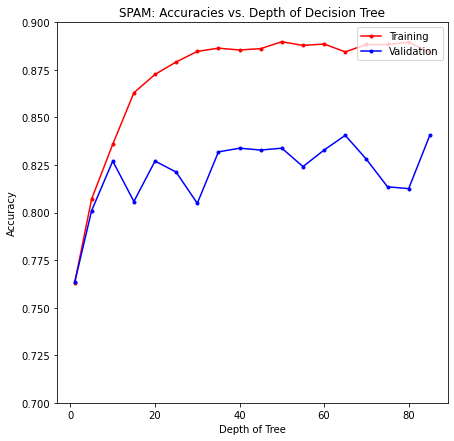

SPAM Base DT Train: 0.8387720570461688; Val: 0.8164251207729468
feature exclamation value 1.0 >/< 1e-05
feature meter value 0.0 >/< 1e-05
feature ampersand value 0.0 >/< 1e-05
feature money value 0.0 >/< 1e-05
feature volumes value 0.0 >/< 1e-05
feature spam value 0.0 >/< 1e-05
feature message value 0.0 >/< 1e-05
feature prescription value 0.0 >/< 1e-05
feature dollar value 0.0 >/< 1e-05
feature pain value 0.0 >/< 1e-05
feature exclamation value 0.0 >/< 1e-05
feature meter value 3.0 >/< 1e-05
SPAM Bagged DT Train: 0.8399806623156877; Val: 0.8222222222222222
predictions saved
Random Forest Train: 0.8339376359680928; Val: 0.8241545893719807


<Figure size 432x288 with 0 Axes>

In [108]:
import numpy as np
import matplotlib.pyplot as plt

if __name__ == "__main__":

    # Spam DATASET
    np.random.seed(267)

    dataset = "spam"

    X, y, Z, features, class_names = getDataset(dataset)

    """
        Visualizing accuracies vs. depth. 
    """
    train_accuracies = []
    valid_accuracies = []
    depths = [1,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85]

    for depth in depths:
        base_dt = DecisionTree(max_depth=depth, feature_labels=features)
        base_train_acc, base_val_acc = evaluateModel(X, y, 4137, base_dt) #, filename="spam_base.csv", Z=Z)
        train_accuracies.append(base_train_acc)
        valid_accuracies.append(base_val_acc)

        print("Depth {} -- Base DT Train: {}; Val: {}".format(depth, base_train_acc, base_val_acc))

    fig, axes = plt.subplots(1, 1, figsize=(7, 7)) 
    axes.plot(depths, train_accuracies, '.r-') 
    axes.plot(depths, valid_accuracies, '.b-') 
    axes.legend(['Training', 'Validation'], loc='upper right') 
    axes.set_title("SPAM: Accuracies vs. Depth of Decision Tree") 
    axes.set_xlabel("Depth of Tree")
    axes.set_ylabel("Accuracy")
    plt.ylim([0.7, .9])
    plt.show()
    plt.savefig("picture")


    """
        Training Decision Tree
    """

    base_dt = DecisionTree(max_depth=10, feature_labels=features)
    base_train_acc, base_val_acc = evaluateModel(X, y, 4137, base_dt)
    print("SPAM Base DT Train: {}; Val: {}".format(base_train_acc, base_val_acc))
    
    spam_sample = X[y==1, :][0,:].reshape(1, 32)
    ham_sample = X[y==0, :][4, :].reshape(1, 32)

    """
        Predictions for spam sample
    """

    base_dt.predict(spam_sample, verbose=True)
 

    """
        Predictions for ham sample
    """

    base_dt.predict(ham_sample, verbose=True)

    """
        Training Bagged Decision Tree
    """

    #crossValBaggedDT(X, y, features, sample_size=3000)
    bagged_dt = BaggedTrees(maxdepth=10, n=50, features=features, sample_size=3000)
    bagged_train_acc, bagged_val_acc = evaluateModel(X, y, 4137, bagged_dt)
    print("SPAM Bagged DT Train: {}; Val: {}".format(bagged_train_acc, bagged_val_acc))

    randforest = RandomForest(maxdepth=10, n=50, features=features, sample_size=3000, m=6)
    rand_train_acc, rand_val_acc = evaluateModel(X, y, 4137, randforest, filename="spam_rf.csv", Z=Z)
    print("Random Forest Train: {}; Val: {}".format(rand_train_acc, rand_val_acc))



### Titanic Kaggle and Writeup

In [109]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pydot

if __name__ == "__main__":

    ##TITANIC DATASET
    np.random.seed(266)

    dataset = "titanic"

    X, y, Z, features, class_names = getDataset(dataset)

    print("Features:", features)
    print("Train/test size:", X.shape, Z.shape)
    print()

    """
        Training Base Decision Tree
    """

    #crossValBaseDT(X, y, features)
    # #Depth 6 indicated best Base Decision Tree Classifier (Titanic)
    base_dt = DecisionTree(max_depth=6, feature_labels=features)
    base_train_acc, base_val_acc = evaluateModel(X, y, 700, base_dt)
    print("Base DT Train: {}; Val: {}".format(base_train_acc, base_val_acc))



    """
        Training shallow decision tree for writeup
    """
    params = {
        "max_depth": 5,
        # "random_state": 6,
        "min_samples_leaf": 10,
    }
    base_dt = DecisionTree(max_depth=3, feature_labels=features)
    base_train_acc, base_val_acc = evaluateModel(X, y, 700, base_dt)
  #  clf = DecisionTreeClassifier(random_state=0, **params)
  #  base_dt.fit(X, y)
  #    evaluate(clf)
    
  #  # For OSX, may need the following for dot: brew install gprof2dot
    
  #  from pydot import graph_from_dot_data
  #  import io

  #  out = io.StringIO()
  #  export_graphviz(clf, out_file=out, feature_names=features, class_names=class_names)
  #  # For OSX, may need the following for dot: brew install gprof2dot
  #  graph = graph_from_dot_data(out.getvalue())
  #  graph_from_dot_data(out.getvalue())[0].write_pdf("%s-tree.pdf" % dataset)
    
    # error in the package

    """
        Training Bagged Decision Tree
    """

    # crossValBaggedDT(X, y, features)
    # #Depth 7 indicated best Bagged DT Classifier (Titanic)
    # number trees, 40
    bagged_dt = BaggedTrees(maxdepth=7, n=40, features=features, sample_size=700)
    bagged_train_acc, bagged_val_acc = evaluateModel(X, y, 700, bagged_dt, filename="titanic_bdt.csv", Z=Z)
    print("Bagged DT Train: {}; Val: {}".format(bagged_train_acc, bagged_val_acc))


    """
        Training Random Forest
    """

    #crossValRF(X, y, features, 4)
    # #Depth 6, N=80 trees works best
    randforest = RandomForest(maxdepth=6, n=80, features=features, sample_size=700, m=4)
    rand_train_acc, rand_val_acc = evaluateModel(X, y, 700, randforest)
    print("Random Forest Train: {}; Val: {}".format(rand_train_acc, rand_val_acc))

Features: [b'pclass', b'sex', b'age', b'sibsp', b'parch', b'fare', b'cabin', b'embarked', b'male', b'female', b'C', b'B', b'D', b'E', b'A', b'F', b'S', b'C', b'Q']
Train/test size: (999, 19) (310, 19)



<ipython-input-4-da1b87ef1986>:95: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  data = genfromtxt(path_train, delimiter=',', dtype=None)
<ipython-input-4-da1b87ef1986>:97: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  test_data = genfromtxt(path_test, delimiter=',', dtype=None)


Base DT Train: 0.8457142857142858; Val: 0.8093645484949833
predictions saved
Bagged DT Train: 0.8657142857142858; Val: 0.7859531772575251
Random Forest Train: 0.8228571428571428; Val: 0.7993311036789298
